# **DSCI 100 009 - Group 165 Report - Pulsar Stars**

 - By Jasmine Bodis, Muhan Yang, Nilay Kumar and Zhedong Wang

## *Introduction*

### 1) Background Information

Pulsar is a neutron star that can produce radio waves detectable from Earth. When it spins at a high speed, scientists can detect its radio wave patterns. For each rotation, the radio wave pattern emitted is distinctive. Therefore, each sample collected in the dataset refers to the average radio waves produced by multiple rotations.

However, not all detected radio waves are produced by pulsars; a majority of the detections are radio frequency interference (RFI) or noise in space instead of real pulsar signals. Therefore, the dataset contains mostly negative class samples (Class 0), which is the detection of RFI/noise.

Integrated pulse profile wave is obtained as the stable fingerprint of pulsars when they increase their signal quality and rotate periodically, and DM-SNR is a unique ratio obtained during their signaling rotation similarly. Using data from these two detections, scientists are possibly able to distinguish pulsar stars from other radio waves through their unique signaling characteristics.

### 2) Question of the Project

Using the mean and excess kurtosis of the integrated profile columns from the pulsar dataset (predictors selection will be justified in Methods later), can we use the knn-classification method to predict whether a signal is from a pulsar star or a radio frequency interference/noise?

### 3) Dataset Description

The dataset we are using is downloaded from UCI Machine Learning Repository. The url is: https://archive.ics.uci.edu/ml/datasets/HTRU2. The name of the dataset is HTRU2, describing a collected sample of pulsar candidates in the High Time Resolution Universe Survey (South) in Keith et al. (2010).

HTRU2 consists of 17,898 samples (rows) and 9 columns in total, with 8 columns of continuous variables and 1 column of class variable represented by 0 (negative) and 1 (positive) which can be used for conducting binary classification problems. The negative class consists of samples of signals caused by radio frequency interference (RFI) and noise, whereas the positive class refers to signals that real pulsar stars created.

Within the 8 continuous variables, the first four refers to the mean, standard deviation, excess kurtosis, and the skewness of the integrated pulse profile wave, and the latter four indicates the same four pieces of statistics but now of the DM-SNR (Dispersion Measure - Signal-to-Noise Ratio) curve created during the signal.

## *Methods & Results*

### *Preliminary Exploratory Data Analysis*

In [2]:
# Downloading the neccessary packages and libraries 
library(tidyverse)
library(readxl)
library(DBI)
library(dbplyr)
library(RPostgres)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 10)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘dbplyr’


The following objects are masked from ‘package:dplyr’:

    ident, sql


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ rec

In [3]:
# Reading in the pulsar star dataset into an object named pulsar
pulsar <- read_csv("https://raw.githubusercontent.com/splashhhhhh/dsci100-grp165/main/HTRU_2.csv", col_names = FALSE)

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Table 1: *Pulsar Dataset - untidy*

In [4]:
pulsar

X1,X2,X3,X4,X5,X6,X7,X8,X9
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
136.4297,59.84742,-0.1878456,-0.73812297,1.296823,12.16606,15.450260,285.931022,0
122.5547,49.48561,0.1279781,0.32306090,16.409699,44.62689,2.945244,8.297092,0
119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173,0


In [5]:
# Cleaning the dataset by adding meaningful column names.
colnames(pulsar) <- c("mean_ip", "sd_ip", "kurt_ip", "skew_ip", "mean_dmsnr", "sd_dmsnr", "kurt_dmsnr", "skew_dmsnr", "class")

# Mutating the class column into a factor.
pulsar <- pulsar |>
    mutate(class = as_factor(class))
pulsar |>
  pull(class) |>
  levels()

[1] "0" "1"

### Table 2: *Cleaned Pulsar Dataset*

In [6]:
pulsar|>
head(10)

mean_ip,sd_ip,kurt_ip,skew_ip,mean_dmsnr,sd_dmsnr,kurt_dmsnr,skew_dmsnr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.1998328,19.110426,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.6772575,14.860146,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.1212375,21.744669,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.6429766,20.959280,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.1789298,11.468720,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.6362876,14.545074,10.621748,131.39400,0
119.48438,48.76506,0.03146022,-0.1121676,0.9991639,9.279612,19.206230,479.75657,0
130.38281,39.84406,-0.15832276,0.3895404,1.2207358,14.378941,13.539456,198.23646,0
107.25000,52.62708,0.45268802,0.1703474,2.3319398,14.486853,9.001004,107.97251,0


First ten rows of the cleaned dataset is shown above.

### Chart 1: *Class 1 vs Class 2 - imbalanced*

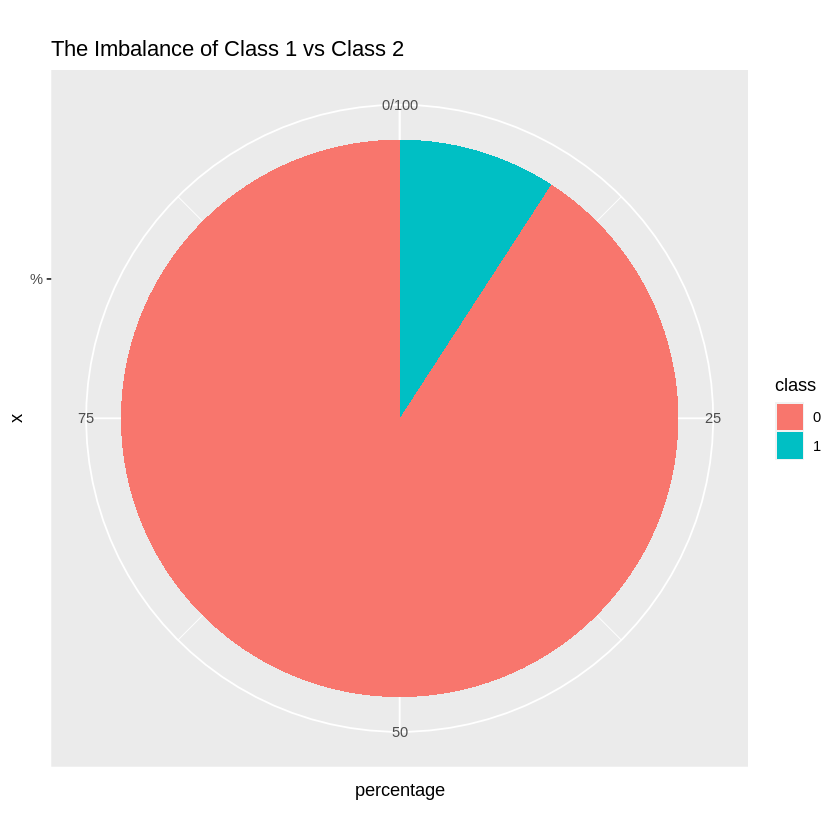

In [18]:
#Calculate the percentage of Class 1 stars vs Class 2 stars || Helps us understand the data
num_obs <- nrow(pulsar)

pulsar |>
    group_by(class) |>
    summarize(count = n(),
             percentage = n() / num_obs * 100) |>
    ggplot(aes(x = "%", y = percentage, fill = class)) +
    geom_col() +
    coord_polar(theta = "y") + 
    ggtitle("The Imbalance of Class 1 vs Class 2")

Since the dataset is originally imbalanced (consisting of 16259 samples from Class 0 and 1639 samples from Class 1 - shown in the pie chart), we used sample_n function to randomly select 1639 samples from Class 0 and combined them with Class 1 using bind_rows to make a balanced dataset with 3278 samples in total. We did this because the predictor variables cannot be derived from the graph created using imbalanced dataset, as the number of samples contained in class 0 were far fewer than the other, arising in class 0 to accumulate at x-axis on the graph.

In [13]:
# Manually downsample dataset
pulsar_0 <- pulsar %>%
filter(class == 0)
# dim(pulsar_0) used for verification.

pulsar_1 <- pulsar %>%
filter(class == 1)
# dim(pulsar_1) used for verification. 

pulsar_0_down <- pulsar_0 %>% sample_n(1639)
# dim(pulsar_0_down) used for verification.

balanced <- bind_rows(pulsar_0_down, pulsar_1)
table(balanced$class) # Now each class contains the same amount of samples


   0    1 
1639 1639 

### Chart 2: *Balanced Pulsar Dataset (downsampled)*

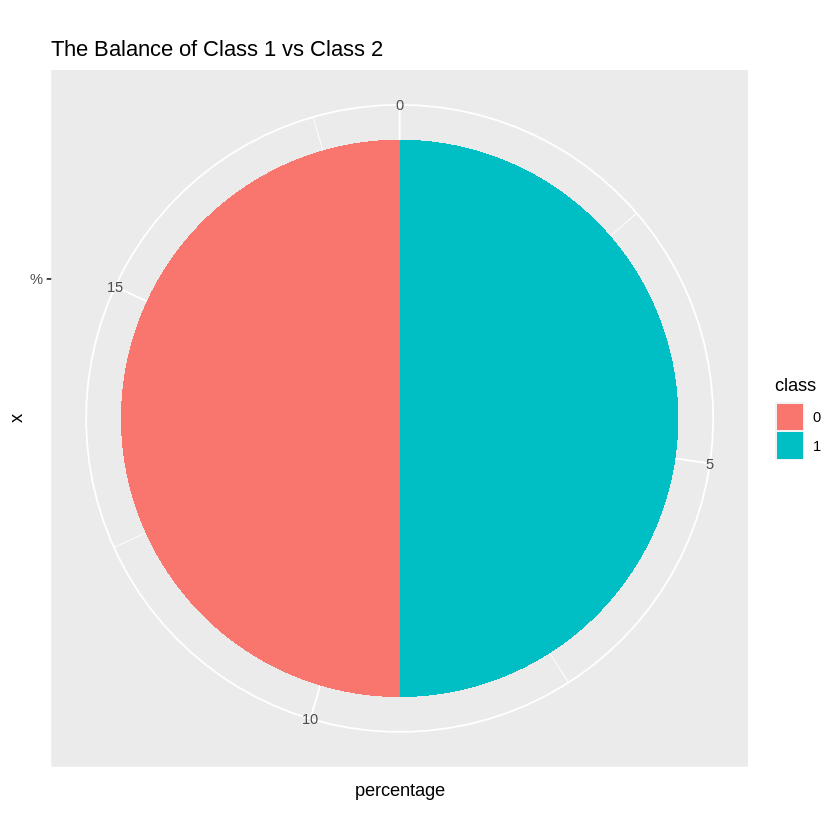

In [19]:
# Confirmitive visualization of the newly downsampled pulsar dataset.
balanced |>
    group_by(class) |>
    summarize(count = n(),
             percentage = n() / num_obs * 100) |>
    ggplot(aes(x = "%", y = percentage, fill = class)) +
    geom_col() +
    coord_polar(theta = "y") +
ggtitle("The Balance of Class 1 vs Class 2")

By visualizing our new dataset with 3278 samples after downsampling, we now confirm that we have a balanced dataset with 50/50 split of each class in the data - real pulsar (class 1) and RFI/noises (class 0).

### Choosing a predictor variable

For choosing predictor variables, we decided to use visualizations we graphed out for eight columns of variables. Since this is a classification problem, variables that have a relatively greater difference in its range and value between class 1 and class 0 can be used to distinguish between two classes better. Selected via histograms, we will choose those variables with a relatively smaller overlap between the two classes.

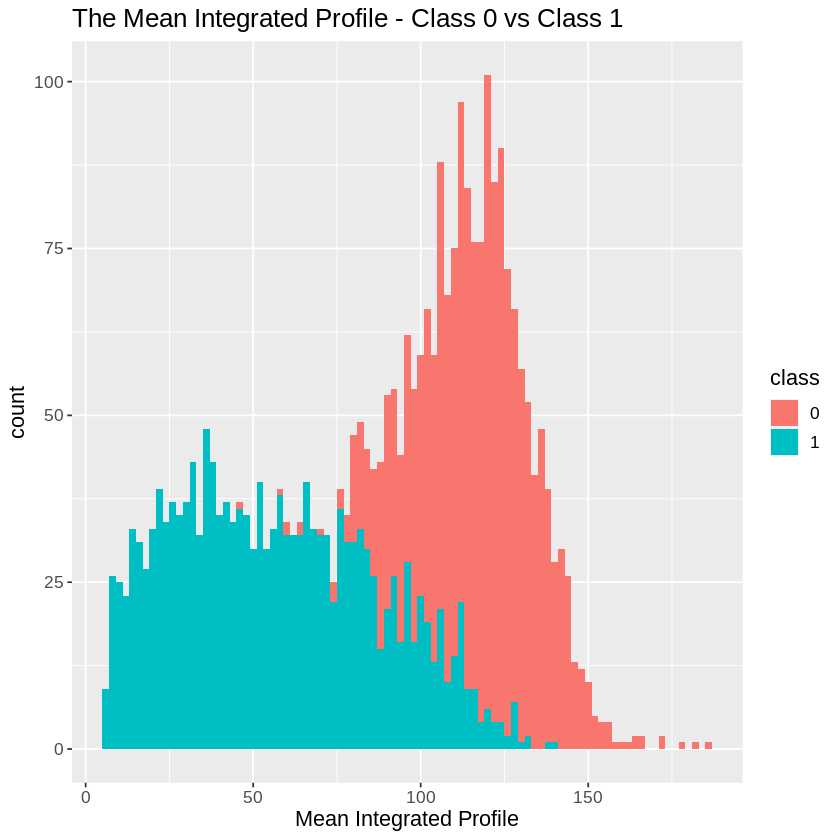

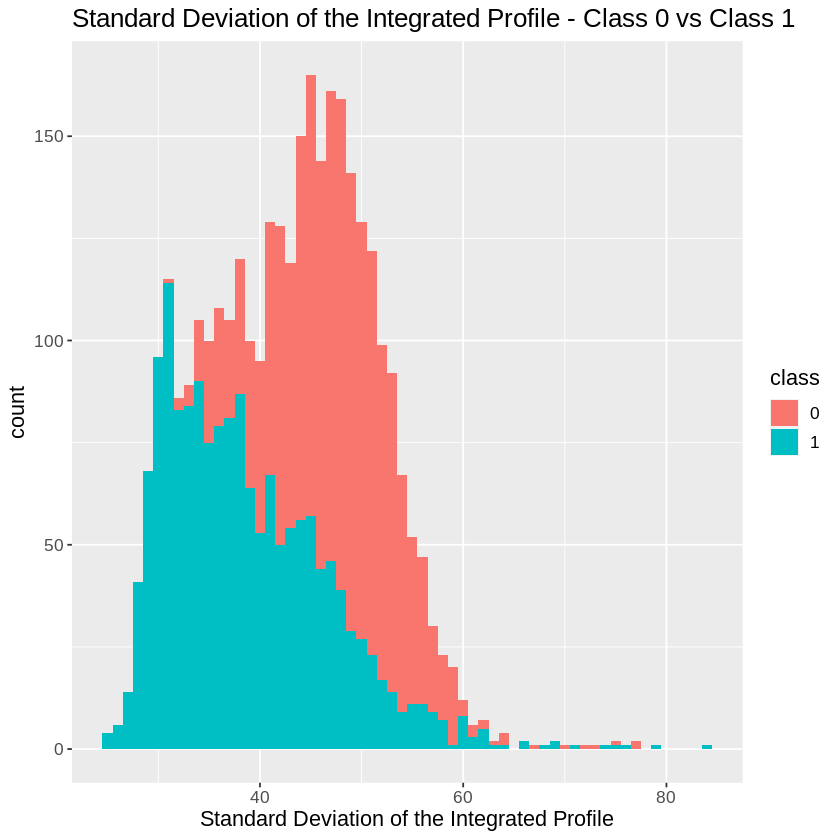

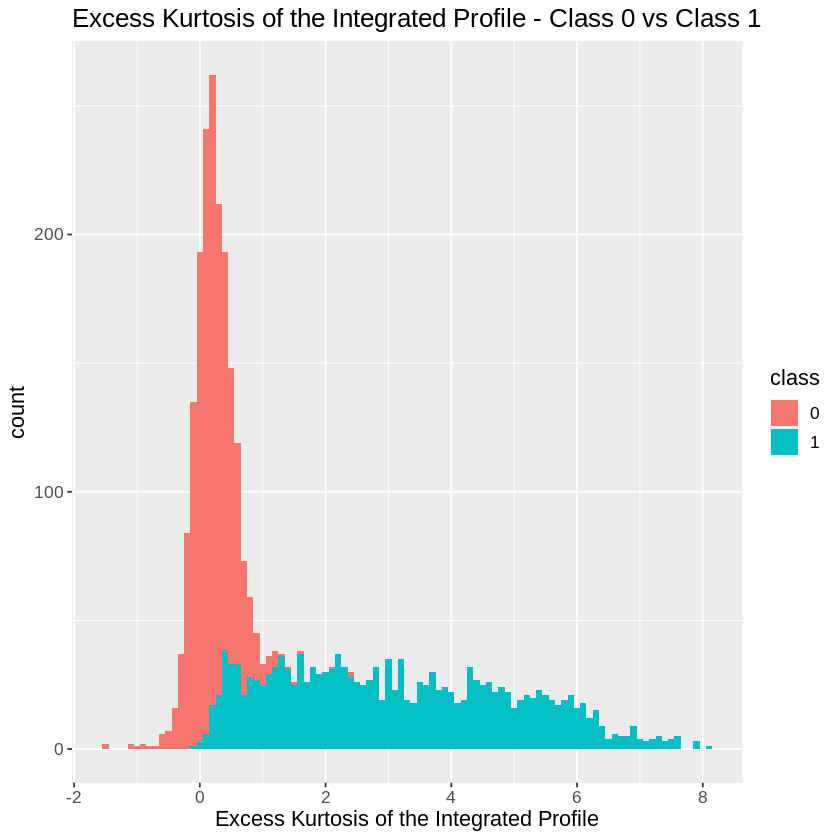

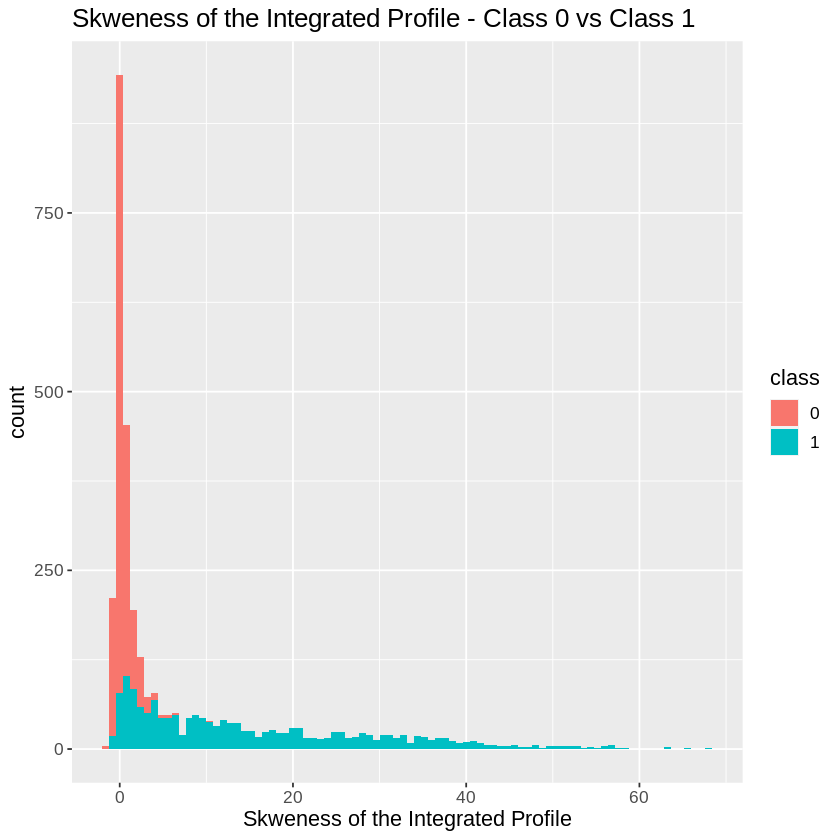

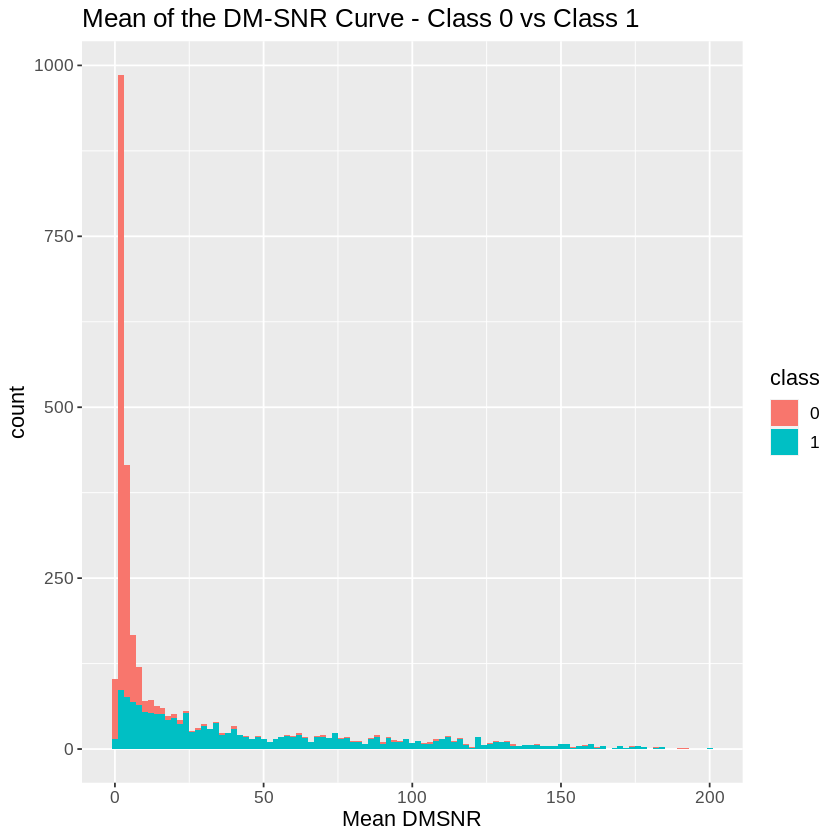

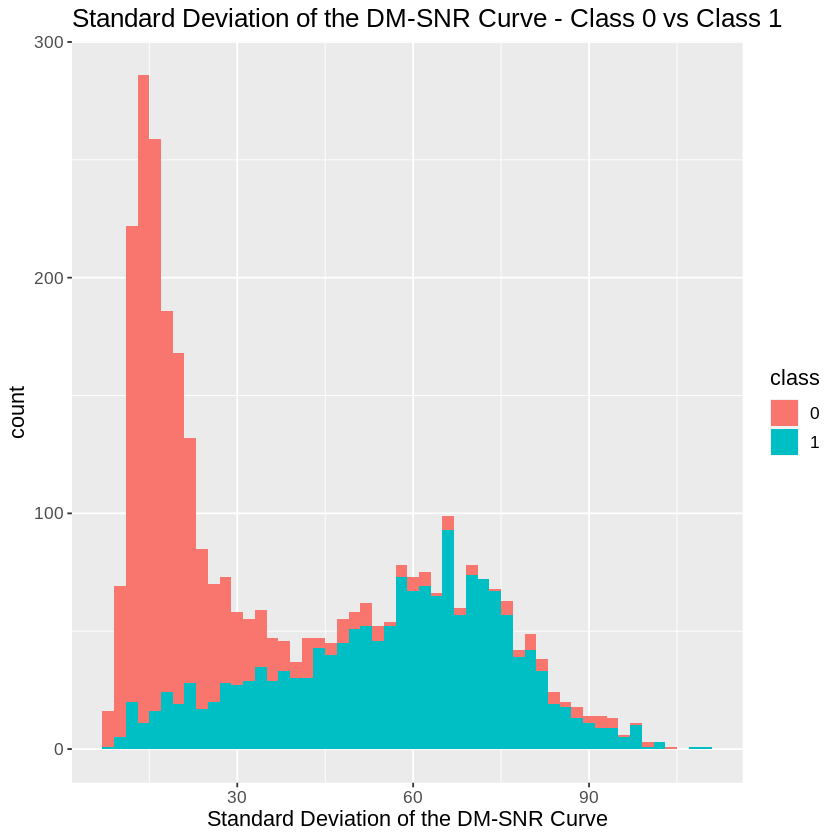

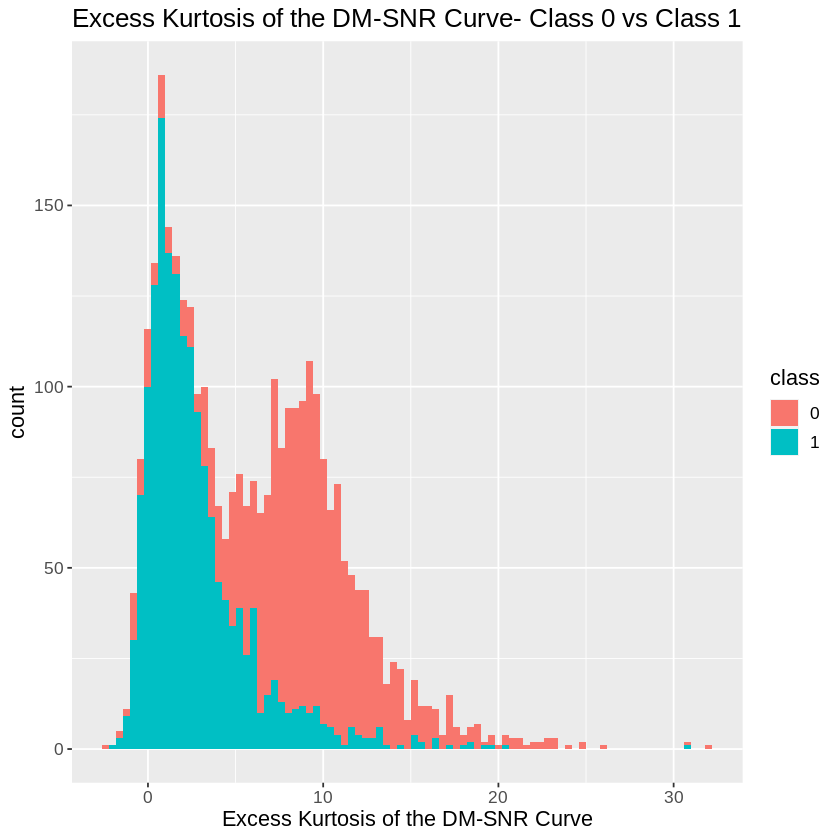

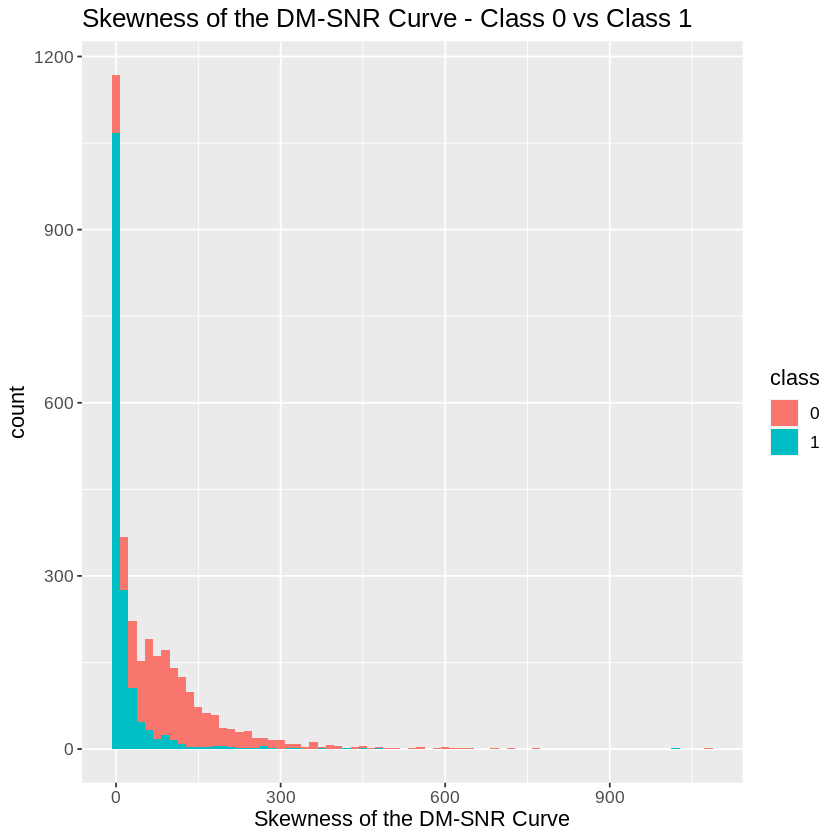

In [10]:
# All histogram charts created to visualize which would be the best predictor variable to use for the classification of pulsar stars. 

# Here we are looking for a defining trait/characteristic of either class 1 or class 0 using the balanced dataset.

# This will be concluded from the visualizations produced (looking at whether or not the class's overlap).
# The less the class overlap, the more accurate our classifier will be with classifying whether a signal is from an actual pulsar
# star or whether it's RFI/noise. 

mean_ip_plot <- balanced |> 
    ggplot(aes(x = mean_ip)) +
    geom_histogram(aes(fill = class), binwidth = 2) + 
    labs(x = "Mean Integrated Profile") +
    theme(text = element_text(size = 13)) + ggtitle("The Mean Integrated Profile - Class 0 vs Class 1")              
mean_ip_plot


sd_ip_plot <- balanced |>
    ggplot(aes(x = sd_ip)) +
    geom_histogram(aes(fill = class), binwidth = 1) + 
    labs(x = "Standard Deviation of the Integrated Profile") +
    theme(text = element_text(size = 13)) + ggtitle("Standard Deviation of the Integrated Profile - Class 0 vs Class 1")            
sd_ip_plot


kurt_ip_plot <- balanced|>
    ggplot(aes(x = kurt_ip)) +
    geom_histogram(aes(fill = class), binwidth = 0.1) + 
    labs(x = "Excess Kurtosis of the Integrated Profile") +
    theme(text = element_text(size = 13)) + ggtitle("Excess Kurtosis of the Integrated Profile - Class 0 vs Class 1")              
kurt_ip_plot

skew_ip_plot <- balanced |>
    ggplot(aes(x = skew_ip)) +
    geom_histogram(aes(fill = class), binwidth = 0.8) + 
    labs(x = "Skweness of the Integrated Profile") +
    theme(text = element_text(size = 13)) + ggtitle("Skweness of the Integrated Profile - Class 0 vs Class 1")             
skew_ip_plot

mean_dmsnr_plot <- balanced |>
    ggplot(aes(x = mean_dmsnr)) +
    geom_histogram(aes(fill = class), binwidth = 2) + 
    labs(x = "Mean DMSNR") +
    theme(text = element_text(size = 13)) + ggtitle("Mean of the DM-SNR Curve - Class 0 vs Class 1")             
mean_dmsnr_plot

sd_dmsnr_plot <- balanced |>
    ggplot(aes(x = sd_dmsnr)) +
    geom_histogram(aes(fill = class), binwidth = 2) + 
    labs(x = "Standard Deviation of the DM-SNR Curve") +
    theme(text = element_text(size = 13)) + ggtitle("Standard Deviation of the DM-SNR Curve - Class 0 vs Class 1")             
sd_dmsnr_plot

kurt_dmsnr <- balanced |>
    ggplot(aes(x = kurt_dmsnr)) +
    geom_histogram(aes(fill = class), binwidth = 0.4) + 
    labs(x = "Excess Kurtosis of the DM-SNR Curve") +
    theme(text = element_text(size = 13)) + ggtitle("Excess Kurtosis of the DM-SNR Curve- Class 0 vs Class 1")             
kurt_dmsnr

skew_dmsnr <- balanced |>
    ggplot(aes(x = skew_dmsnr)) +
    geom_histogram(aes(fill = class), binwidth = 15) + 
    labs(x = "Skewness of the DM-SNR Curve") +
    theme(text = element_text(size = 13)) + ggtitle("Skewness of the DM-SNR Curve - Class 0 vs Class 1")             
skew_dmsnr

After plotting, we decided to use the mean and the excess kurtosis of the integrated profile, because from visualizing 8 variables by histograms, mean_ip and kurt_ip had the smallest overlap between two classes.

For example, for mean_ip, the highest frequency of class 1 occurs between 0-100, while the highest frequency of class 0 happens between 50-150. For kurt_ip, class 0 data mainly locates around 0, but class 1 data scatters between 0-6.

In [11]:
sum(is.na(pulsar))

[1] 0

Since the sum function above is equal to 0, we have no rows with missing data.

By selecting two with the most obvious range differences between class 0 and 1, we can use them as our predictors to develop a classification model to predict whether a new signal belongs to the radio wave caused by RFI and noise or real pulsar stars. In Data Analysis, we will create a k-nearest neighbours model using two predictors selected from above, tune it via 5-fold cross-validation, and evaluate its accuracy using our testing datasets.

### Data Analysis

Now that we have our balanced dataset and predictor variables, we can use tidymodels to perform K-nearest neighbour classification.

In [47]:
set.seed(2020)

# Splitting data into a test set and training set so we can properly use KNN-classification.
pulsar_split <- initial_split(balanced, prop = 0.75, strata = class)
pulsar_training <- training(pulsar_split)
pulsar_testing <- testing(pulsar_split)


# Data reprocessing in a recipe, ensuring the data is scaled.
pulsar_recipe <- recipe(class ~ mean_ip + kurt_ip, data = pulsar_training) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

# Creating the model.
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |> #chose K = 5
      set_engine("kknn") |>
      set_mode("classification")

# Fitting the model in a workflow.
pulsar_fit <- workflow() |>
      add_recipe(pulsar_recipe) |>
      add_model(knn_spec) |>
      fit(data = pulsar_training)

# Tuning the model : cross validation
pulsar_vfold <- vfold_cv(pulsar_training, v = 5, strata = class)

# This function will allow us to run a cross-validation on each train/validation split we created in the previous question.
pulsar_resample_fit <- workflow() |>
      add_recipe(pulsar_recipe) |>
      add_model(knn_spec) |>
      fit_resamples(resamples = pulsar_vfold)

pulsar_metrics <- collect_metrics(pulsar_resample_fit)

# Tuning K.
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
        set_engine("kknn") |>
      set_mode("classification")

# Create a new workflow for K tuning. 
knn_results <- workflow() |>
      add_recipe(pulsar_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = pulsar_vfold, grid = 10) |>
      collect_metrics()

# To find the best value for the number of neighbors.
accuracies <- knn_results |> 
    filter(.metric == "accuracy")

# K accuracy plot.
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.87, 1.0)) + # adjusting the y-axis
      ggtitle("Accuracy vs K")

### Chart 3: Accuracy Plot

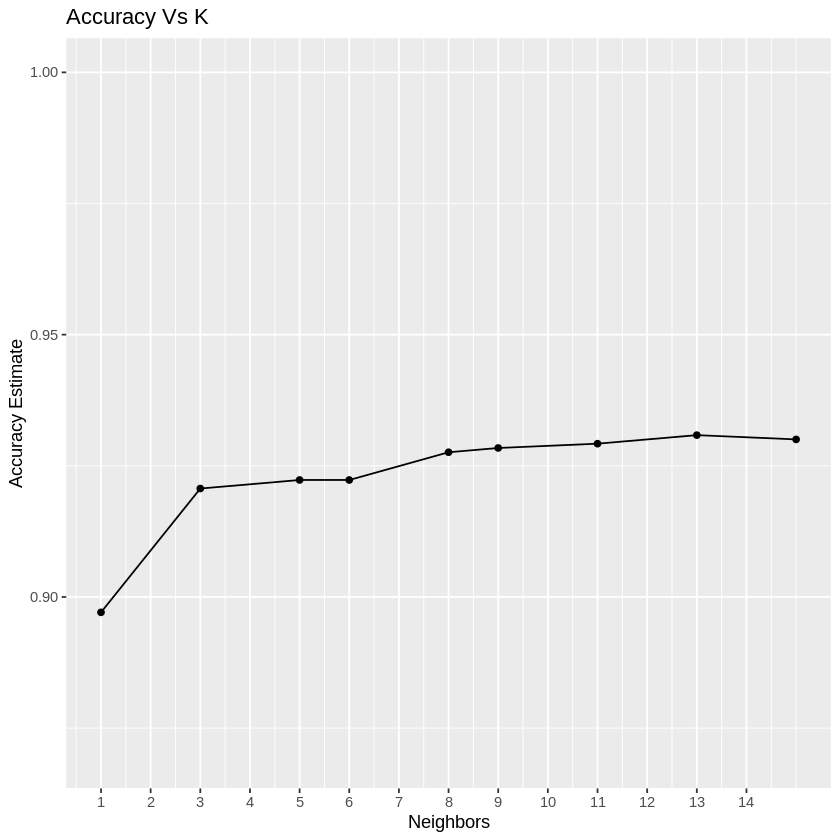

In [46]:
accuracy_versus_k

By using the plot above, we can concur that using a K value from 9-13 would provide the highest accuracy.

In [41]:
#                                              Performing K-nearest neighbors (KNN) & Checking Accuracy
set.seed(2020)

# add the column of predictions to the original test data.
pulsar_test_predictions <- predict(pulsar_fit, pulsar_testing) |>
      bind_cols(pulsar_testing)

# Checking the classifiers accuracy.
pulsar_prediction_accuracy <- pulsar_test_predictions |>
     metrics(truth = class, estimate = .pred_class)             

# creating a confusion matrix to show us the table of predicted labels and correct labels.
pulsar_mat <- pulsar_test_predictions |> 
    conf_mat(truth = class, estimate = .pred_class)

### Table 3: Pulsar Prediction Accuracy

In [42]:
pulsar_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9097561
kap,binary,0.8195122


The estimated accuracy of our KNN model is 91.2%.

## *Discussion*

### 1) Summary of what we found

The HTRUS dataset is an imbalanced dataset across its two classes - 0 (RFI/noise) and 1 (real pulsar), with only 9.16% of class 1 data and 90.84% of class 0 data in it, as being visualized in the pie chart. After balancing the dataset by randomly selecting 1639 pieces of data from 16259 pieces of data in class 0, the balanced dataset consists of 50% from each class.

A K-nearest Neighbour Classification is performed by splitting 75% data to the training set and 25% data to the testing set. After using cross-validation to calculate an accuracy for each value of K in a reasonable range and plotting the estimated accuracy versus different K values using line graph, we conclude that using a K value from 9-13 would provide the highest accuracy to the classification problem in pulsar dataset.

We also checked on the estimated accuracy of the classifier, which is about 91.2%.

### 2) Discussion on what we expected to find

The result is consistent with what we expected to find. We primarily expected to differentiate whether signals are from actual pulsar stars or simply RFI noise by using the K-nearest neighbour classification, and using testing dataset to obtain its estimated accuracy.

In our project, we built a KNN model, obtained a range of k in highest accuracy by using cross-validation and line graph visualization, and tested on its accuracy using the testing dataset. Since the estimated accuracy is 91.2%, we can expect using the K-nearest neighbour classifier to differentiate whether signals are from actual pulsar stars or simply RFI noise.

### 3) Impact of the findings

According to Debesai et al. (2020), pulsar stars are valuable in science, because they release highly regular and periodic signals. Identifying a pulsar star and finding deviated signals from its normal period can help to detect gravity waves, dark matter, and other cosmic phenomena (Debesai et al., 2020). Our model helps to correctly identify pulsar stars and distinguish them from the RFI and noises in space. This enables astrophysicists to utilize the pulsar stars and its feature of periodicity in signaling more efficiently.

However, even though we randomly selected 1639 data (the same amount of data in class 1) from class 0, the original class 0 consists of approximately 9-10 times of our selected sample (16259 class 0 samples in the original dataset), making our random selection process relatively weak to represent the entire sample from the dataset. This might negatively impact the accuracy of the model. In addition, the imbalanced nature of the dataset itself and the fact that we are not able to upscale data from class 1 kept us from increasing the accuracy of our model.

### 4) Future Questions

Future scope for research can be to strive to improve the accuracy of the model, since classification methods like KNN classification can be challenging when the dataset is imbalance, that is, the data from one class is significantly more than that of the other class. 

Shi (2020) suggested three ways to improve the performance of KNN model in imbalanced dataset: random oversampling, random undersampling, or ensemble oversampling to the training data. Here, we employed a random undersampling way to down the amount of larger class data. Further investigation can focus on determining which data sampling algorithm has the most efficacy to fit the best for this specific classification problem of pulsar stars and RFI noise, and trying to obtain a best solution of having an imbalanced dataset.

In addition, as the predictor variables in our model was only derived from visualization directly, future study can focus on performing statistical tests to find the strength of correlation between class 1 and class 0 for each variable and determine the strongest ones as predictors (Debesai et al., 2020).

## *References*

Debesai, S., Gutierrez, C., & Ugur Koyluoglu, N. (2020). Application of machine learning methods to identify and categorize radio pulsar signal candidates. 11.


Keith, M. J., Jameson, A., Van Straten, W., Bailes, M., Johnston, S., Kramer, M., Possenti, A., Bates, S. D., Bhat, N. D. R., Burgay, M., Burke-Spolaor, S., D’Amico, N., Levin, L., McMahon, P. L., Milia, S., & Stappers, B. W. (2010). The High Time Resolution Universe Pulsar Survey - I. System configuration and initial discoveries: HTRU - I. System configuration. Monthly Notices of the Royal Astronomical Society, 409(2), 619–627. https://doi.org/10.1111/j.1365-2966.2010.17325.x


Shi, Z. (2020). Improving k-Nearest Neighbors Algorithm for Imbalanced Data Classification. *IOP Conference Series: Materials Science and Engineering*, 719(1), 012072. https://doi.org/10.1088/1757-899X/719/1/012072